## Imports

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder

In [5]:
# !pip install torchsummary #incase its not installed

In [7]:
import torchsummary

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import v2

In [9]:
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report


In [10]:
import seaborn as sns
from pathlib import Path

In [12]:
train_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
train_path = 'dataset1\\Training\\Training'
label_list = ['notsmoking','smoking']
img_list = glob(train_path+'\*.jpg')

In [13]:
label_list

['notsmoking', 'smoking']

In [14]:
for img in img_list:
    file_name = os.path.splitext(img)[0].split("\\")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id":0} , index=[1])
        train_df = pd.concat([train_df , new_data] , ignore_index = True)
    elif file_name[0:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index=[1])
        train_df = pd.concat([train_df , new_data] , ignore_index = True)

In [15]:
train_df.head()

,path,label,class_id
0,dataset1\Training\Training\notsmoking_0001.jpg,notsmoking,0.0
1,dataset1\Training\Training\notsmoking_0002.jpg,notsmoking,0.0
2,dataset1\Training\Training\notsmoking_0003.jpg,notsmoking,0.0
3,dataset1\Training\Training\notsmoking_0005.jpg,notsmoking,0.0
4,dataset1\Training\Training\notsmoking_0007.jpg,notsmoking,0.0


In [16]:
train_df.dtypes

path         object
label        object
class_id    float64
dtype: object

In [17]:
#changing data types of the DataFrame
train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [20]:
val_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
val_path = "dataset1\\Validation\\Validation"
img_list = glob(val_path + "\*.jpg")

In [21]:
for img in img_list:
    file_name = os.path.splitext(img)[0].split("\\")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id":0} , index = [1])
        val_df = pd.concat([val_df , new_data]  , ignore_index=True)
    elif file_name[:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index = [1])
        val_df = pd.concat([val_df , new_data] , ignore_index=True)

In [22]:
val_df[['path']] = val_df[['path']].astype(str)
val_df[['label']] = val_df[['label']].astype(str)
val_df[['class_id']] = val_df[['class_id']].astype(int)

In [23]:
val_df

,path,label,class_id
0,dataset1\Validation\Validation\notsmoking_0006...,notsmoking,0
1,dataset1\Validation\Validation\notsmoking_0017...,notsmoking,0
2,dataset1\Validation\Validation\notsmoking_0024...,notsmoking,0
3,dataset1\Validation\Validation\notsmoking_0029...,notsmoking,0
4,dataset1\Validation\Validation\notsmoking_0034...,notsmoking,0
...,...,...,...
175,dataset1\Validation\Validation\smoking_0534.jpg,smoking,1
176,dataset1\Validation\Validation\smoking_0542.jpg,smoking,1
177,dataset1\Validation\Validation\smoking_0545.jpg,smoking,1
178,dataset1\Validation\Validation\smoking_0556.jpg,smoking,1


<Axes: xlabel='count', ylabel='label'>

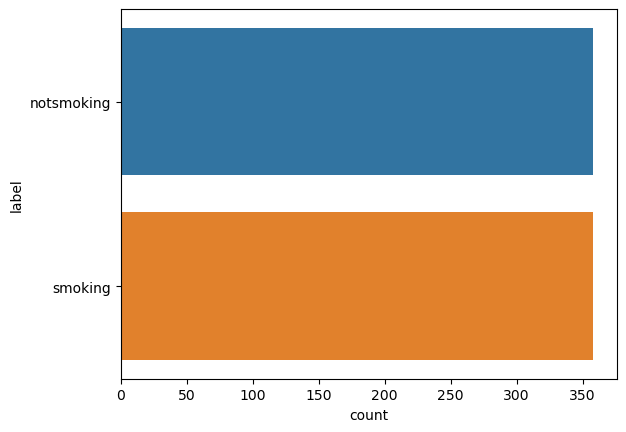

In [24]:
#ploting smoking vs non-smoking as mere count
sns.countplot(data = train_df , y = 'label')

<Axes: xlabel='count', ylabel='label'>

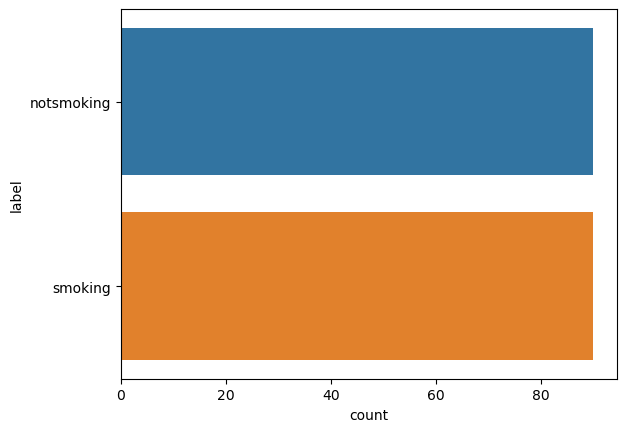

In [25]:
sns.countplot(data = val_df , y = 'label')

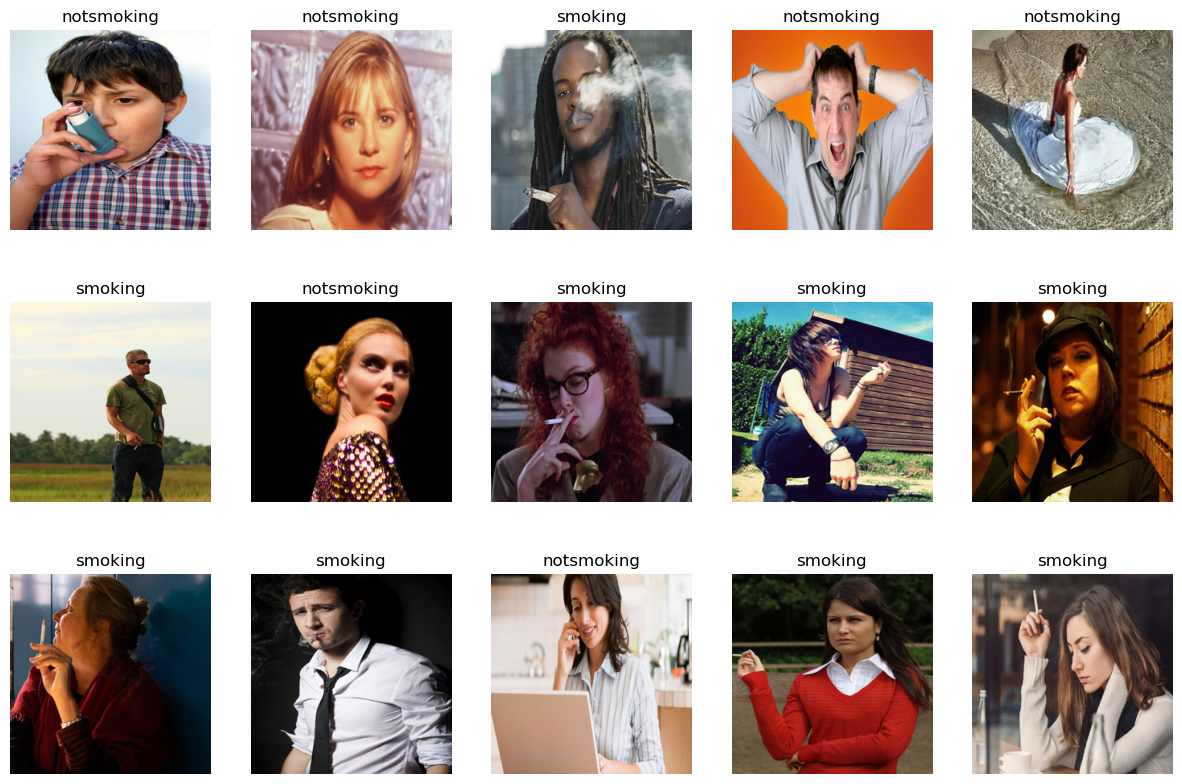

In [26]:
#showing some samples
show_imgs = 15
idx = np.random.randint(0,len(train_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [28]:
# Creating Transformations
train_transforms = v2.Compose([
    v2.Resize(265),
    v2.RandomResizedCrop(size = (224 , 224) , antialias = True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomVerticalFlip(.5),
    v2.RandomAffine(degrees=(-10,10),translate=(.1,.1), scale=(.9,1.1)),
    v2.RandomErasing(p=.5,scale = (.1,.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean = [.485,.456,.406] , std = [0.229 , 0.224 , 0.225])
])

In [29]:
test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean = [.485,.456,.406] , std = [0.229 , 0.224 , 0.225])
])

## Creating Dataset

In [30]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id


In [31]:
BATCH_SIZE = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#num_workers = 2 if device == 'cude' else 4

train_dataset = MyDataset(train_df , train_transforms)
val_dataset = MyDataset(val_df , test_transforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)

In [32]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")

train_data: 716
val_data:180


## Create Model

In [35]:
class_size = len(label_list)
model = models.swin_v2_b(weights= 'DEFAULT')


In [36]:
model.head = nn.Linear(in_features = model.head.in_features,
                       out_features = class_size)
model(torch.randn((16,3,224,224))).shape


torch.Size([16, 2])

## Traing and validation

In [37]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)
    
    model.train()
    epoch_loss , epoch_correct = 0 , 0
    
    for i ,(data_ , target_) in enumerate(dataloader):
        target_ = target_.type(torch.LongTensor)
        data_ , target_ = data_.to(device) , target_.to(device)
        
        
        
        outputs = model(data_)
        
        loss = loss_fn(outputs , target_)
        epoch_loss =+ loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ , pred = torch.max(outputs , dim = 1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
        size += target_.shape[0]
    lr_scheduler.step()
    return epoch_correct/size , epoch_loss / num_batches
        

In [38]:
def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad():
        model.eval()
        for i, (data_ , target_) in enumerate(dataloader):
            target_ = target_.type(torch.LongTensor)
            data_ , target_ = data_.to(device) , target_.to(device)  
            
            outputs = model(data_)
            
            loss = loss_fn(outputs , target_)
            
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs , dim = 1)
            epoch_correct += torch.sum(pred == target_).item()
            
            size+= target_.shape[0]
    return epoch_correct/size  , epoch_loss / num_baches

In [48]:
EPOCHS = 50
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
momentum = .9
weight_decay = .1

optmizer = torch.optim.AdamW(model.parameters() , lr = learning_rate)

lr_milestones = [7 , 14, 21 , 28 , 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optmizer ,
                                                   milestones=lr_milestones,
                                                   gamma = .1)

#Early stopping parameters
patience = 20
counter = 0
best_loss = np.inf

In [49]:
model.to(device)

for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   model ,
                                   criterion ,
                                   optmizer ,
                                   multi_step_lr_scheduler)
    val_acc , val_loss = test(val_loader , model , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optmizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict() , "checkpoints\\best.pth")
    else:
        counter+=1
    if counter >= patience:
        print("Early stop !")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

epoch:0     train_loss = 0.0020 , train_acc:0.8156     val_loss = 0.2495 , val_acc:0.9111     learning rate: 0.0001


  2%|▏         | 1/50 [00:16<13:13, 16.19s/it]

epoch:1     train_loss = 0.0072 , train_acc:0.8059     val_loss = 0.2166 , val_acc:0.8889     learning rate: 0.0001


  6%|▌         | 3/50 [00:54<14:44, 18.81s/it]

epoch:2     train_loss = 0.0004 , train_acc:0.8380     val_loss = 0.3057 , val_acc:0.8667     learning rate: 0.0001
epoch:3     train_loss = 0.0021 , train_acc:0.8394     val_loss = 0.2124 , val_acc:0.9056     learning rate: 0.0001


  8%|▊         | 4/50 [01:23<17:28, 22.79s/it]

epoch:4     train_loss = 0.0002 , train_acc:0.8310     val_loss = 0.1896 , val_acc:0.9278     learning rate: 0.0001


 12%|█▏        | 6/50 [02:21<19:19, 26.36s/it]

epoch:5     train_loss = 0.0055 , train_acc:0.8478     val_loss = 0.3360 , val_acc:0.8611     learning rate: 0.0001


 14%|█▍        | 7/50 [02:49<19:18, 26.94s/it]

epoch:6     train_loss = 0.0012 , train_acc:0.8324     val_loss = 0.4294 , val_acc:0.8333     learning rate: 1e-05


 16%|█▌        | 8/50 [03:17<19:10, 27.39s/it]

epoch:7     train_loss = 0.0003 , train_acc:0.8687     val_loss = 0.2496 , val_acc:0.9111     learning rate: 1e-05


 18%|█▊        | 9/50 [03:45<18:47, 27.49s/it]

epoch:8     train_loss = 0.0028 , train_acc:0.9162     val_loss = 0.2350 , val_acc:0.9111     learning rate: 1e-05


 20%|██        | 10/50 [04:07<17:16, 25.90s/it]

epoch:9     train_loss = 0.0001 , train_acc:0.9162     val_loss = 0.2187 , val_acc:0.9222     learning rate: 1e-05


 22%|██▏       | 11/50 [04:23<14:47, 22.77s/it]

epoch:10     train_loss = 0.0001 , train_acc:0.9218     val_loss = 0.2472 , val_acc:0.9167     learning rate: 1e-05


 24%|██▍       | 12/50 [04:39<13:14, 20.92s/it]

epoch:11     train_loss = 0.0048 , train_acc:0.9344     val_loss = 0.2306 , val_acc:0.9222     learning rate: 1e-05


 26%|██▌       | 13/50 [04:56<12:01, 19.49s/it]

epoch:12     train_loss = 0.0002 , train_acc:0.9260     val_loss = 0.2434 , val_acc:0.9222     learning rate: 1e-05


 28%|██▊       | 14/50 [05:11<11:00, 18.34s/it]

epoch:13     train_loss = 0.0006 , train_acc:0.9190     val_loss = 0.2175 , val_acc:0.9278     learning rate: 1.0000000000000002e-06


 30%|███       | 15/50 [05:27<10:11, 17.47s/it]

epoch:14     train_loss = 0.0034 , train_acc:0.9246     val_loss = 0.2111 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [05:42<09:32, 16.83s/it]

epoch:15     train_loss = 0.0001 , train_acc:0.9413     val_loss = 0.2049 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [05:57<08:59, 16.34s/it]

epoch:16     train_loss = 0.0002 , train_acc:0.9274     val_loss = 0.2062 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [06:13<08:34, 16.06s/it]

epoch:17     train_loss = 0.0002 , train_acc:0.9274     val_loss = 0.2079 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [06:28<08:14, 15.96s/it]

epoch:18     train_loss = 0.0000 , train_acc:0.9316     val_loss = 0.2060 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 40%|████      | 20/50 [06:44<07:53, 15.79s/it]

epoch:19     train_loss = 0.0004 , train_acc:0.9413     val_loss = 0.2052 , val_acc:0.9333     learning rate: 1.0000000000000002e-06


 42%|████▏     | 21/50 [06:59<07:33, 15.65s/it]

epoch:20     train_loss = 0.0002 , train_acc:0.9260     val_loss = 0.2010 , val_acc:0.9333     learning rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [07:14<07:14, 15.51s/it]

epoch:21     train_loss = 0.0000 , train_acc:0.9372     val_loss = 0.2023 , val_acc:0.9333     learning rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [07:30<06:59, 15.55s/it]

epoch:22     train_loss = 0.0001 , train_acc:0.9413     val_loss = 0.2024 , val_acc:0.9333     learning rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [07:45<06:43, 15.53s/it]

epoch:23     train_loss = 0.0064 , train_acc:0.9539     val_loss = 0.2032 , val_acc:0.9333     learning rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [08:01<08:41, 20.05s/it]

epoch:24     train_loss = 0.0015 , train_acc:0.9330     val_loss = 0.2039 , val_acc:0.9333     learning rate: 1.0000000000000002e-07
Early stop !


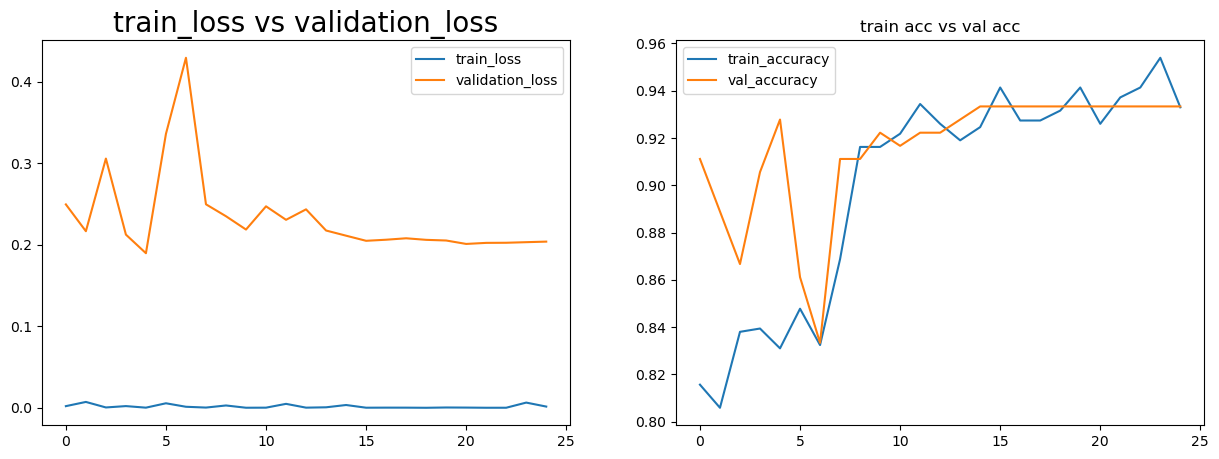

In [50]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='train_loss')
plt.plot(logs['val_loss'] , label = 'validation_loss')
plt.title('train_loss vs validation_loss' , fontsize = 20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'] , label = 'train_accuracy')
plt.plot(logs['val_acc'] , label = 'val_accuracy')
plt.title('train acc vs val acc')
plt.legend()

## Metrics

In [56]:
test_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
test_path = 'dataset1\\Testing\\Testing'
img_list = glob(test_path + "\*.jpg")
for img in img_list:
    file_name = os.path.splitext(img)[0].split("\\")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id": 0} , index = [1])
        test_df = pd.concat([test_df , new_data] , ignore_index = True)
    elif file_name[:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index = [1])
        test_df = pd.concat([test_df , new_data] , ignore_index = True)
        
        

In [57]:
test_df[["path"]] = test_df[["path"]].astype(str) 
test_df[["label"]] = test_df[["label"]].astype(str) 
test_df[["class_id"]] = test_df[["class_id"]].astype(int) 

In [58]:
test_dataset = MyDataset(test_df , test_transforms)
test_loader = DataLoader(test_dataset , batch_size= BATCH_SIZE)

In [59]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()

y_true , y_pred = [] , []

with torch.no_grad():
    for (data_ , target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_ , target_ = data_.to(device) , target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs , dim = 1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████| 38/38 [00:01<00:00, 24.12it/s]


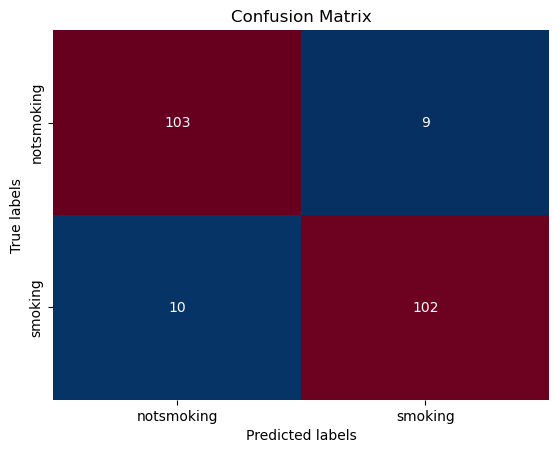

: 

In [60]:
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
